# Анализ результатов A/B-теста

## ЛЕГЕНДА
Вас срочно вызвали на новый проект, так что теперь вы аналитик в туристической фирме.
Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы.

Стоимость туров:

- Таиланд — 100000 рублей;
- Турция — 60000 рублей;
- Мальдивы — 200000 рублей;
- Санкт-Петербург — 10000 рублей;
- Камчатка — 150000 рублей.
- Проверьте, какая из страниц приносит больше покупок.

## ЗАДАЧИ
1. Провести первичный анализ датасета.
В рамках этой задачи вам предстоит:

- привести столбцы к корректным типам данных;
- убедиться, что данные по обеим группам представлены за одинаковый период (визуализировать);
- проверить корректность распределения участников теста;
- проверить различие в группах;
- проверить пересечение аудитории в группах;
- определить по группам ряд показателей (количество пользователей, количество покупок, выручку, конверсию, средний чек);
- посмотреть, как распределяются суммы покупок (здесь необходимо повизуализировать);
- сделать первичные выводы.

2. Рассчитайте кумулятивные метрики:
- постройте график конверсии в группах по дням;
- постройте график среднего чека в группах по дням;
- постройте график кумулятивных метрик по конверсии и по среднему чеку;
- сделайте выводы.

3. Проведите статистическую проверку гипотез:
- о равенстве конверсии;
- о равенстве выручки;
- о равенстве средних чеков по дням.

4. Сделайте вывод.

## РЕШЕНИЕ

### Проверка данных

In [702]:
import pandas as pd
import scipy.stats as st 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import numpy as np

In [703]:
df = pd.read_csv('ab_data.csv') 

In [704]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  294478 non-null  int64 
 1   user_id     294478 non-null  int64 
 2   date        294478 non-null  object
 3   group       294478 non-null  object
 4   purchase    294478 non-null  int64 
 5   price       294478 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.5+ MB


In [705]:
# Приведение типов данных
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

In [706]:
df.head(5)

,Unnamed: 0,user_id,date,group,purchase,price
0,0,851104,2021-01-21,A,0,0
1,1,804228,2021-01-12,A,0,0
2,2,661590,2021-01-11,B,0,0
3,3,853541,2021-01-08,B,0,0
4,4,864975,2021-01-21,A,1,150000


In [707]:
df.describe(include='all')

C:\Users\sgari\AppData\Local\Temp\ipykernel_12924\2884002236.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,Unnamed: 0,user_id,date,group,purchase,price
count,294478.000000,294478.000000,294478,294478,294478.000000,294478.000000
unique,NaN,NaN,23,2,NaN,NaN
top,NaN,NaN,2021-01-08 00:00:00,B,NaN,NaN
freq,NaN,NaN,13564,147276,NaN,NaN
first,NaN,NaN,2021-01-02 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2021-01-24 00:00:00,NaN,NaN,NaN
mean,147238.500000,787974.124733,NaN,NaN,0.119659,10154.782361
std,85008.620623,91210.823776,NaN,NaN,0.324563,35153.824872
min,0.000000,630000.000000,NaN,NaN,0.000000,0.000000
25%,73619.250000,709032.250000,NaN,NaN,0.000000,0.000000


In [708]:
# Какое количество посещений сайта в группах А и В?

df['group'].value_counts()

B    147276
A    147202
Name: group, dtype: int64

In [709]:
# Какая разница в процентном выражении между группами? Удовлетворяет ли она условию, что разница не должна быть больше 1%?

diff = (df['group'].value_counts()[0]  / df['group'].value_counts()[1]) -1

round(diff*100, 3)

0.05

Разница 0.05%. Распределение сработало корректно. Продолжаем тест, так как разница не превышает 1%.

In [710]:
# Есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей?
dfa = df[df['group'] == 'A']
dfb = df[df['group'] == 'B']

common_users = dfa.merge(
    dfb,
    on='user_id',
    how='inner'
)
common_users['user_id'].nunique()

1895

1895 пользователей

#### Исключите пользователей, оказавшихся в обеих группах
Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей.

In [711]:
# Сколько пользователей осталось в группах после исключения?

common_users_list  = list(common_users['user_id'].unique())

df = df[~df['user_id'].isin(common_users_list)]
df['group'].value_counts()

B    145381
A    145307
Name: group, dtype: int64

In [712]:
# Разница в количестве сессий по прежнему отличается менее, чем на 1%?

df_a = df[df['group'] == 'A']
df_b = df[df['group'] == 'B']

diff2 = (df['group'].value_counts()[0]  / df['group'].value_counts()[1]) -1

display(round(diff2*100, 3))
display(abs(round(diff2*100, 3))<1)

0.051

True

#### Соберите показатели конверсии и среднего чека по каждой группе
где user_id — количество пользователей в группе; 

purchase — количество покупок в группе; 

price — сумма всех покупок в группе. 

В получившуюся таблицу добавьте показатели конверсии и среднего чека по каждой группе.

In [713]:
df_group = df.groupby(['group']).agg({'user_id':'count','purchase':'sum', 'price': 'sum'}).reset_index()

df_group['conversion'] = round(df_group.purchase / df_group.user_id *100, 2)

df_group['avg_cheq'] = round(df_group.price / df_group.purchase, 2)


df_group

,group,user_id,purchase,price,conversion,avg_cheq
0,A,145307,17487,1417780000,12.03,81076.23
1,B,145381,17290,1533010000,11.89,88664.55


#### Какие первичные выводы вы можете сделать?
Несмотря на то что в группе B было больше посетителей, (относительная) конверсия в группе B меньше на 1.16%. За счёт меньшей конверсии в группе B было меньше покупок, однако выручка группы B больше выручки группы A на 115230000 единиц, или 7.5%. Большая выручка в группе B складывается за счёт того, что средний чек группы B выше среднего чека группы A.

Постройте гистограмму по выручке для группы A и для группы B. Какие выводы вы можете сделать?

In [714]:
df['revenue'] = df.purchase * df.price

In [715]:
df_a = df[(df['group'] == 'A') &  (df['revenue'] != 0)]

fig = px. histogram (
    data_frame=df_a, 
    x='revenue', 
    height=350, 
    width=700, 
    title='A, Диаграмма выручки',
    
)
fig.show()

df_b = df[(df['group'] == 'B') &  (df['revenue'] != 0)]
fig = px. histogram (
    data_frame=df_b, 
    x='revenue', 
    height=350, 
    width=700, 
    title='B. Диаграмма выручки',
    color_discrete_sequence=['crimson']
    
)
fig.show()

Участники группы A чаще покупают туры за 60000 рублей, при этом реже покупают туры за 100000 рублей. В остальном покупательская способность обеих групп похожа.

## Кумулятивная таблица и метрики

Есть несколько способов создать кумулятивную таблицу.
Воспользуйтесь одним из них и создайте кумулятивную таблицу для каждой из групп, так чтобы в ней были представлены следующие данные:
- дата;
- количество пользователей (кумулятивное);
- количество заказов (кумулятивное);
- выручка (кумулятивная).

In [716]:
df.head()

,Unnamed: 0,user_id,date,group,purchase,price,revenue
0,0,851104,2021-01-21,A,0,0,0
1,1,804228,2021-01-12,A,0,0,0
2,2,661590,2021-01-11,B,0,0,0
3,3,853541,2021-01-08,B,0,0,0
4,4,864975,2021-01-21,A,1,150000,150000


In [717]:
df_piv = df.groupby(['date', 'group']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()
  
df_piv.head()

,date,group,user_id,purchase,price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


In [718]:
df_piv['ave_price'] = round(df_piv['price'] / df_piv['purchase'], 2)
df_piv['conversion'] = round(df_piv['purchase'] / df_piv['user_id'], 2)

df_piv.head()

,date,group,user_id,purchase,price,ave_price,conversion
0,2021-01-02,A,2854,359,29410000,81922.01,0.13
1,2021-01-02,B,2861,345,29660000,85971.01,0.12
2,2021-01-03,A,6596,748,62000000,82887.70,0.11
3,2021-01-03,B,6619,754,65960000,87480.11,0.11
4,2021-01-04,A,6566,799,64250000,80413.02,0.12


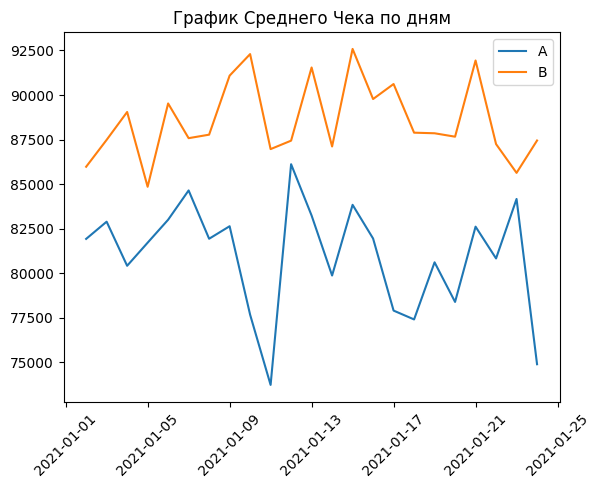

In [719]:
# график среднего чека по дням
plt.plot(df_piv[df_piv['group'] == 'A']['date'], df_piv[df_piv['group'] == 'A']['ave_price'], label='A')
plt.plot(df_piv[df_piv['group'] == 'B']['date'], df_piv[df_piv['group'] == 'B']['ave_price'], label='B')
plt.title('График Среднего Чека по дням') #Название графика
plt.xticks(rotation = 45) # Разворот названия дат на оси X на 45 градусов
plt.legend() 
plt.show() 

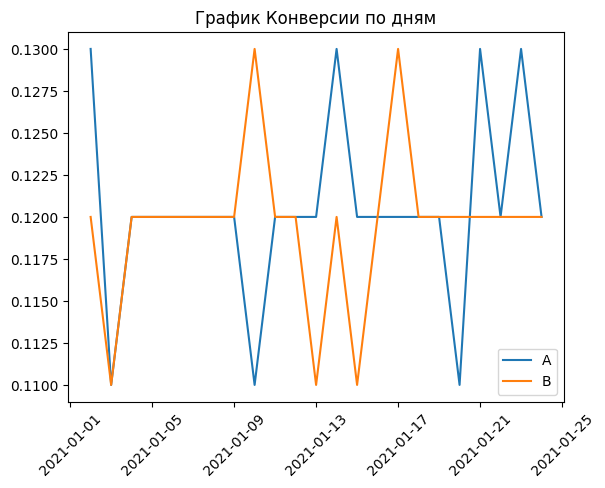

In [720]:
# график конверсии по дням
plt.plot(df_piv[df_piv['group'] == 'A']['date'], df_piv[df_piv['group'] == 'A']['conversion'], label='A')
plt.plot(df_piv[df_piv['group'] == 'B']['date'], df_piv[df_piv['group'] == 'B']['conversion'], label='B')
plt.title('График Конверсии по дням') #Название графика
plt.xticks(rotation = 45) # Разворот названия дат на оси X на 45 градусов
plt.legend() 
plt.show() 

In [723]:
def cummulative_table(data, group): 
    df_cumm = [] 
    for i in data['date'].unique(): 
        out = data[(data['date'] <= i) & (data['group'] == group)].groupby('group')\
                .agg({'date':'max', 'user_id':'sum', 'purchase':'sum', 'price':'sum'}) 
        df_cumm.append(out) 
    return pd.concat(df_cumm).reset_index() 

In [724]:
cumm_a = cummulative_table(df_piv, 'A') 
cumm_b = cummulative_table(df_piv, 'B') 

cumm_a.head(5)

,group,date,user_id,purchase,price
0,A,2021-01-02,2854,359,29410000
1,A,2021-01-03,9450,1107,91410000
2,A,2021-01-04,16016,1906,155660000
3,A,2021-01-05,22449,2696,220210000
4,A,2021-01-06,29055,3460,283620000


In [725]:
#Какая суммарная выручка была в группе А на 15 января?
cumm_a[cumm_a['date']=='2021-01-15']['price']

13    865120000
Name: price, dtype: int64

In [726]:
cumm_a['conversion'] = cumm_a['purchase']/cumm_a['user_id']
cumm_b['conversion'] = cumm_b['purchase']/cumm_b['user_id']

In [727]:
# Какая кумулятивная конверсия была в группе B на 20 января?
round(cumm_b[cumm_b['date']=='2021-01-20']['conversion'],5)

18    0.11896
Name: conversion, dtype: float64

In [728]:
cumm_a['avg_cheq'] = cumm_a['price']/cumm_a['purchase']
cumm_b['avg_cheq'] = cumm_b['price']/cumm_b['purchase']

In [729]:
# Какой кумулятивный средний чек был в группе А на 12 января?
round(cumm_a[cumm_a['date']=='2021-01-12']['avg_cheq'], 2)

10    81491.83
Name: avg_cheq, dtype: float64

In [731]:
cumm_a.head()

,group,date,user_id,purchase,price,conversion,avg_cheq
0,A,2021-01-02,2854,359,29410000,0.125788,81922.005571
1,A,2021-01-03,9450,1107,91410000,0.117143,82574.525745
2,A,2021-01-04,16016,1906,155660000,0.119006,81668.415530
3,A,2021-01-05,22449,2696,220210000,0.120094,81680.267062
4,A,2021-01-06,29055,3460,283620000,0.119084,81971.098266


#### Постройте график кумулятивного среднего чека по дням

Выведите кривые обеих групп на одном графике.

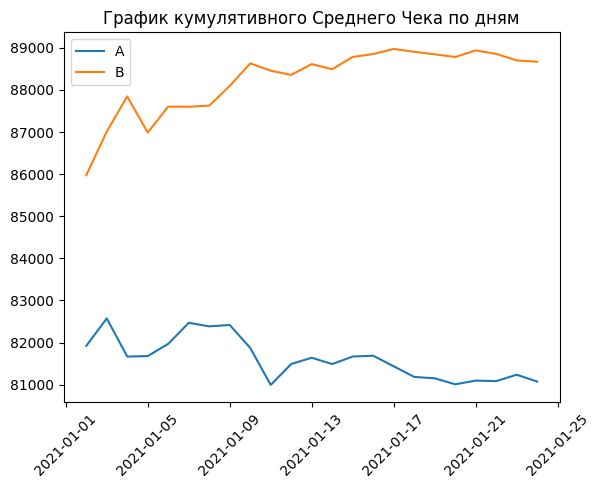

In [732]:
plt.plot(cumm_a['date'], cumm_a['avg_cheq'],  label='A')
plt.plot(cumm_b['date'], cumm_b['avg_cheq'],  label='B')
plt.title('График кумулятивного Среднего Чека по дням') 
plt.xticks(rotation = 45) 
plt.legend() 
plt.show()

#### Постройте график кумулятивной конверсии

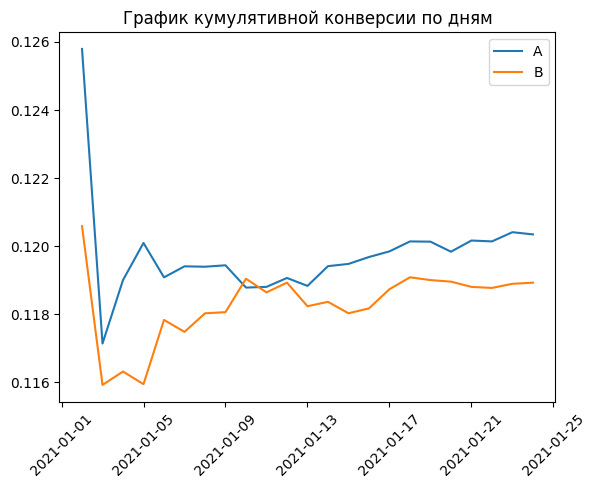

In [ ]:
plt.plot(cumm_a['date'], cumm_a['conversion'],  label='A')
plt.plot(cumm_b['date'], cumm_b['conversion'],  label='B')
plt.title ('График кумулятивной конверсии по дням') 
plt.xticks(rotation = 45) 
plt.legend() 
plt.show() 

### ВЫВОДЫ ПО ГРАФИКАМ КОМУЛЯТИВНОЙ КОНВЕРСИИ
Изначально конверсия группы B была ниже конверсии группы А, однако она показывала стабильный рост, и примерно 10 января конверсия группы B стала выше конверсии группы А. После чего конверсия группы B зафиксировалась примерно на этом уровне (с колебаниями). В то время как конверсия группы А начала постепенно расти. В результате конверсия группы А стабильно выше группы B. Но средний чек группы B выше среднего чека группы А.

### Проверьте распределение показателей конверсии в группах

<Axes: >

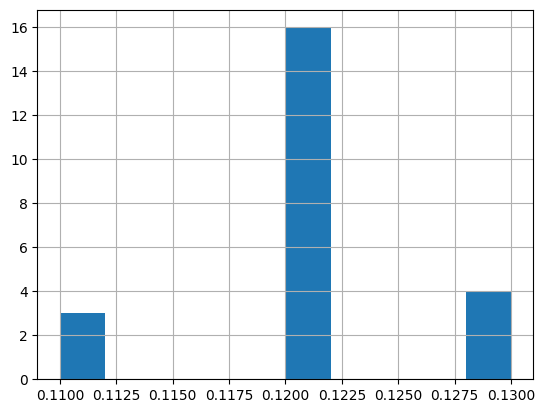

In [737]:
df_piv[df_piv['group'] == 'A']['conversion'].hist()

<Axes: >

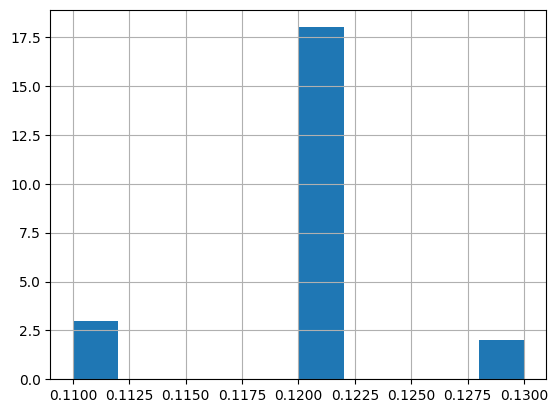

In [738]:
df_piv[df_piv['group'] == 'B']['conversion'].hist()

<Axes: >

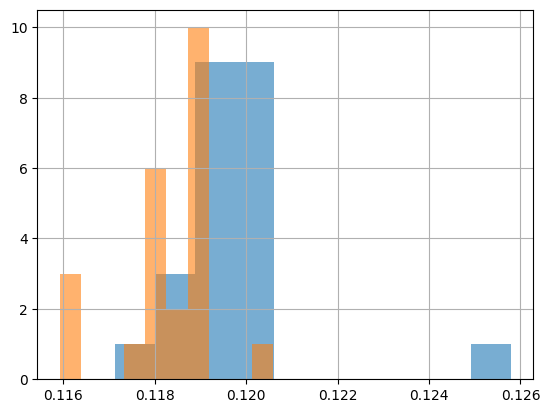

In [736]:
cumm_a['conversion'].hist(alpha= 0.6)
cumm_b['conversion'].hist(alpha= 0.6)

Распределение похоже на нормальное.

### Z-тест
Сделаем Z-тест для проверки гипотезы о равенстве конверсии

### Сформулируйте нулевую и альтернативную гипотезы

H0: Конверсии обеих групп равны; 


H1: Конверсии групп не равны.

Проведите выбранный тест с уровнем статистической значимости, равным 0.05

In [744]:
alpha = 0.05
n_a = cumm_a[cumm_a['date']=='2021-01-24']['user_id']
n_b = cumm_b[cumm_b['date']=='2021-01-24']['user_id']

x_a = cumm_a[cumm_a['date']=='2021-01-24']['purchase']
x_b = cumm_b[cumm_b['date']=='2021-01-24']['purchase']

p_a = x_a/n_a 
p_b = x_b/n_b 

p = (x_a+x_b)/(n_a+n_b)

In [747]:
#Распределение примерно равномерное 50/50
(n_b/n_a)/2

22    0.500255
Name: user_id, dtype: float64

In [748]:
# Расчет Z статистики
diff = p_a- p_b

z = diff / mth.sqrt(p * (1 - p) * (1/n_a + 1/n_b))
z

22    1.176469
dtype: float64

In [757]:
# Теперь из полученной Z-статистики рассчитаем p-value при нормальном стандартном распределении.


p_val = 2 * (1 - st.norm.cdf(abs(z)))

p_val[0]

0.23940749849829834

In [760]:
p_val[0] < alpha

False

### Какой вывод мы можем сделать?
P-value больше принятого уровня значимости, следовательно, статистически значимая разница между конверсиями отсутствует.

### Проверьте различия в стоимости заказов между группами
Сформулируйте нулевую и альтернативную гипотезы.

H0: Стоимости заказов групп равны; 

H1: Стоимости заказов групп не равны

##  Проверка гипотезы о равенстве среднего чека
#### Посмотрите на распределение стоимости заказов
Постройте гистограмму стоимости покупок.

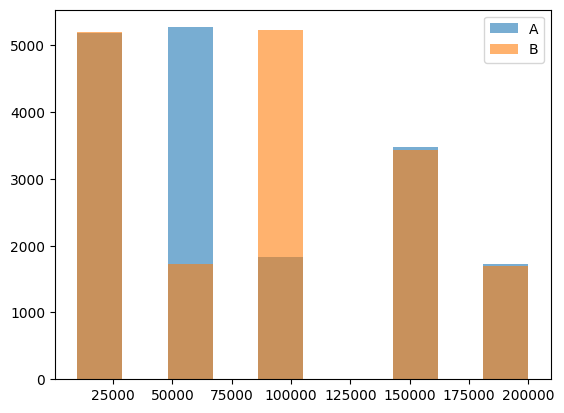

In [764]:
plt.hist(df[(df['group']=='A') & (df['price']!=0)]['price'], label='A', alpha=0.6)
plt.hist(df[(df['group']=='B') & (df['price']!=0)]['price'], label='B', alpha=0.6)
plt.legend() 
plt.show()

#### Распределение не похоже на нормальное

### Применим тест Манна-Уитни для проверки нулевой гипотезы

Проведите выбранный тест с уровнем статистической значимости, равным 0.05

In [ ]:
df.head()

,Unnamed: 0,user_id,date,group,purchase,price,revenue
0,0,851104,2021-01-21,A,0,0,0
1,1,804228,2021-01-12,A,0,0,0
2,2,661590,2021-01-11,B,0,0,0
3,3,853541,2021-01-08,B,0,0,0
4,4,864975,2021-01-21,A,1,150000,150000


In [765]:
alpha = 0.05

In [766]:
dfa = df[(df['group']=='A') & (df['purchase'] == 1)]['price']
dfb = df[(df['group']=='B') & (df['purchase'] == 1) ]['price']

In [767]:
results = st.mannwhitneyu(dfa, dfb)
results

MannwhitneyuResult(statistic=139547139.0, pvalue=2.825361345286736e-37)

In [768]:
results.pvalue < alpha

True

In [770]:
display('p-value: ', results.pvalue)
if (results.pvalue < alpha):
   print("Отвергаем нулевую гипотезы - средние чеки не равны")
else:
   print("Не отвергаем нулевую гипотезу - Средний чеки обеих групп равны")

'p-value: '

2.825361345286736e-37

Отвергаем нулевую гипотезы - средние чеки не равны


#### ВЫВОД по гипотизе:
Отвергаем нулевую гипотезу: стоимости заказов не равны.

## Проверьте различие средних чеков по дням
Ранее вы делали таблицу, в которой собирали показатель среднего чека по каждому дню (не кумулятивный). Проверьте различие средних чеков по дням. Постройте гистограмму.

Сформулируем нулевую гипотезу:

Н0: Средние чеки групп равны

Н1: Средние чеки групп не равны

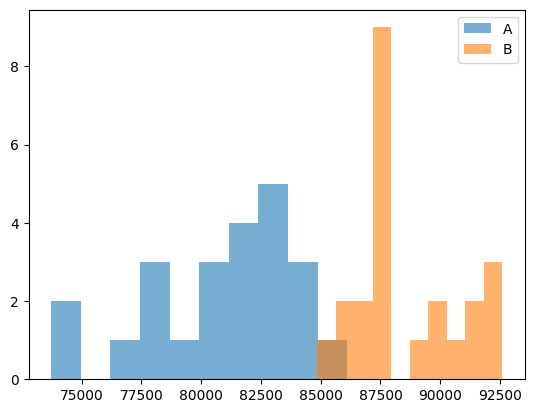

In [771]:
plt.hist(df_piv[df_piv['group'] == 'A']['ave_price'], label='A', alpha=0.6)
plt.hist(df_piv[df_piv['group'] == 'B']['ave_price'], label='B', alpha=0.6)
plt.legend() 
plt.show() 

Распределение по средним чека для групп A и B по дням похоже на нормальное.

Для проверки нулевой гипотезы применим T-тест

In [773]:
alpha = 0.05

In [774]:
results1 = st.ttest_ind(df_piv[df_piv['group'] == 'A']['ave_price'].values, 
                       df_piv[df_piv['group'] == 'B']['ave_price'].values)
results1

Ttest_indResult(statistic=-9.609060180794826, pvalue=2.2523650297552113e-12)

In [775]:
print('p-value', results1.pvalue)

if (results1.pvalue < alpha):
   print("Отвергаем нулевую гипотезы - Cредние чеки по дняям не равны")
else:
   print("Не отвергаем нулевую гипотезу - Средние чеки по дням равны")

p-value 2.2523650297552113e-12
Отвергаем нулевую гипотезы - Cредние чеки по дняям не равны


# ВЫВОД
Несмотря на то что конверсия группы B ниже, статистической значимости в конверсии не достигнуто, соответственно, считать конверсии разными оснований нет. Зато средний чек группы B значительно выше среднего чека группы A. Статистическая значимость достигнута. Вариант сайта B приносит значимо больше выручки, чем вариант сайта A. Рекомендуем признать, что вариант B лучше, чем вариант A!